In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
#検証データの前処理
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))                                
])
#学習データの前処理
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),#データの拡張。ランダムに画像を反転
    transforms.ColorJitter(),#データの拡張。明るさや色相をランダムに変える
    transforms.RandomRotation(10),#データの拡張。画像の±10度の回転
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))                                
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)#学習データセット
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)#検証データセット

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)#学習時には読み込みをランダムにするためにシャッフルをTrueにする
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [8]:
data_iter = iter(train_dataloader)#学習データの画像とラベルをとって格納。32個ずつにバッチ化されている

In [9]:
imgs, labels = data_iter.next()#最初のバッチの32個のデータとそのラベルを格納

In [10]:
labels

tensor([5, 6, 6, 2, 5, 4, 2, 1, 1, 9, 4, 9, 7, 0, 4, 5, 5, 4, 5, 2, 3, 6, 1, 9,
        6, 2, 9, 7, 8, 5, 6, 8])

In [11]:
imgs.size()

torch.Size([32, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


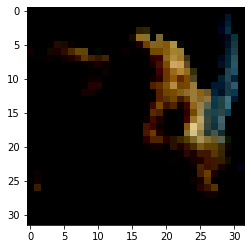

In [12]:
img = imgs[0]
img_permute = img.permute(1, 2, 0)#imgに格納されている画像を表示するためにチャンネルファーストからチャンネルラスト方式へ変更
plt.imshow(img_permute)

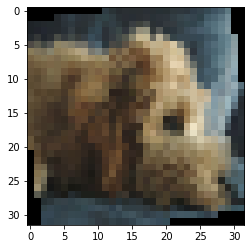

In [13]:
img_permute = 0.5*img_permute + 0.5
img_permute = np.clip(img_permute, 0, 1)
plt.imshow(img_permute) 

ラベル番号は5で犬だったが、たしかに犬の画像だった

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):#num_classesは何クラスに分類するのかを示す
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),#畳み込み
            nn.ReLU(inplace=True),#活性化関数
            nn.MaxPool2d(kernel_size=2),#プーリング層.32/2=16,つまり16*16のサイズに縮小された
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#プーリング層.16/2=8,つまり8*8のサイズに縮小された
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#プーリング層.8/2=4,つまり4*4のサイズに縮小された
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4*4*128, out_features=num_classes)#全結合層
    def forward(self, x):
      x = self.features(x)#(4,4,128)の三次元配列を格納。4*4のサイズの画像が128枚あるという意味
      x = x.view(x.size(0), -1)#x.size()は(32,128,4,4)=(バッチ数、チャンネル数、縦サイズ、横サイズ)
      x = self.classifier(x)
      return x

In [15]:
model = CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [17]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)#読み込んだ入力データをGPUに送る
        labels = labels.to(device)
        optimizer.zero_grad()#勾配の初期化
        output = model(imgs)#入力データをモデルに入力
        loss = criterion(output, labels)#損失関数で誤差を計算
        loss.backward()#誤差逆伝播
        running_loss += loss.item()#誤差を格納
        pred = torch.argmax(output, dim=1)#画像がどのクラスに属するか予測
        running_acc += torch.mean(pred.eq(labels).float())#予測精度を格納
        optimizer.step()#重みの更新
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    #
    #以下検証データのループ validation_loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader) 
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}, \
        val_loss: {}, val_acc: {} ".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.4345104505217998, acc: 0.4741082787513733,         val_loss: 1.084914456541165, val_acc: 0.6135183572769165 
epoch: 1, loss: 1.0093940188697113, acc: 0.643813967704773,         val_loss: 0.8997600267108637, val_acc: 0.6826078295707703 
epoch: 2, loss: 0.8578103695133903, acc: 0.6972168684005737,         val_loss: 0.7831671898738264, val_acc: 0.7266373634338379 
epoch: 3, loss: 0.7863114454085752, acc: 0.7240883111953735,         val_loss: 0.7498878097762696, val_acc: 0.7406150102615356 
epoch: 4, loss: 0.7250806060992062, acc: 0.7475807666778564,         val_loss: 0.7110713407064018, val_acc: 0.7555910348892212 
epoch: 5, loss: 0.6892368715692619, acc: 0.7600567936897278,         val_loss: 0.7027484494657181, val_acc: 0.7541933059692383 
epoch: 6, loss: 0.6584715309981268, acc: 0.7704734802246094,         val_loss: 0.6643552153636092, val_acc: 0.7732627391815186 
epoch: 7, loss: 0.6343539409143987, acc: 0.7783909440040588,         val_loss: 0.6647282385121519, val_acc

エポック数が増えるにつれて、学習データと検証データの誤差lossは減少していき、学習データと検証データの精度は増していく。過学習は起きておらず学習はうまくいっていると思われる。

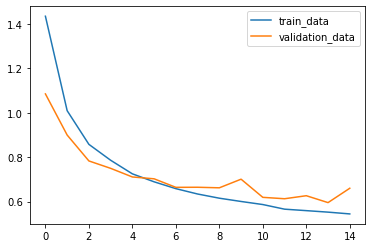

In [18]:
#誤差の図示
plt.plot(losses, label='train_data')
plt.plot(val_losses, label='validation_data')
plt.legend()

上図より、やはり過学習は起きておらず学習は上手くいったと言える。